In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

Datasets loaded successfully!
Training Data Shape: (614, 13)
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1    

In [ ]:
# Loading the datasets
df_train = pd.read_csv('loan_train.csv')
df_test = pd.read_csv('loan_test.csv')
print("Datasets loaded successfully!")
print(f"Training Data Shape: {df_train.shape}")
print(df_train.head())

#### **Step 2: Data Cleaning & Preprocessing**

We need to handle missing values and convert text data (like "Male"/"Female") into numbers so the Random Forest model can understand them.

In [3]:
# Function to clean and preprocess data
def preprocess_data(df):
    df = df.copy()

    # 1. Handle Missing Values
    # Numerical columns: Fill with Mean or Median
    # Categorical columns: Fill with Mode (most frequent value)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

    # 2. Drop Loan_ID as it is not useful for prediction
    if 'Loan_ID' in df.columns:
        df = df.drop('Loan_ID', axis=1)

    # 3. Convert Categorical Columns to Numbers (Label Encoding)
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])

    return df

# Apply preprocessing
# Note: We preprocess training data. We will split this later for evaluation.
df_train_clean = preprocess_data(df_train)

print("Data Cleaned Successfully!")
print(df_train_clean.info())

Data Cleaned Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
None


#### **Step 3: Data Visualization**

Your project requires at least one visualization. Let's look at the target variable (`Loan_Status`) to see the balance of approved vs. rejected loans.

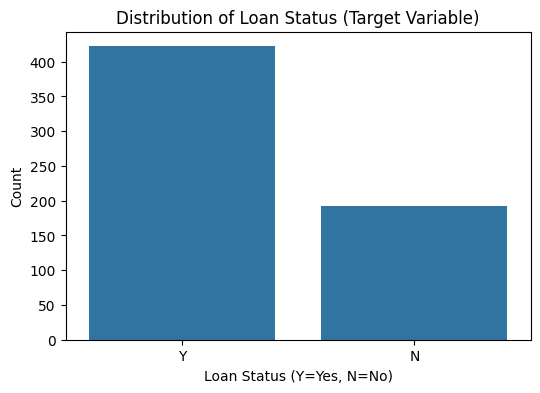

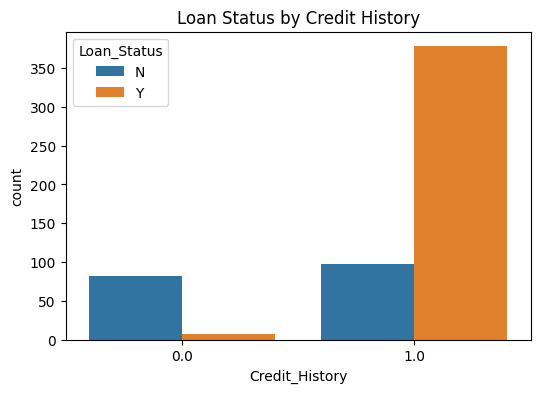

In [4]:
# Visualization: Loan Status Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df_train)
plt.title('Distribution of Loan Status (Target Variable)')
plt.xlabel('Loan Status (Y=Yes, N=No)')
plt.ylabel('Count')
plt.show()

# Extra Visualization: Credit History vs Loan Status
plt.figure(figsize=(6, 4))
sns.countplot(x='Credit_History', hue='Loan_Status', data=df_train)
plt.title('Loan Status by Credit History')
plt.show()

---

### **Phase 2: Model Development (Random Forest)**

Now we train the model.

In [5]:
# 1. Define Features (X) and Target (y)
# Assuming 'Loan_Status' is the target column
X = df_train_clean.drop('Loan_Status', axis=1)
y = df_train_clean['Loan_Status']

# 2. Split into Training and Validation Sets (80% Train, 20% Test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predictions
y_pred = rf_model.predict(X_val)

# 5. Evaluation
print("Model Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# 6. Save the model for Deployment
joblib.dump(rf_model, 'loan_model.joblib')
print("Model saved as 'loan_model.joblib'")

Model Accuracy: 0.7560975609756098

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.42      0.55        43
           1       0.75      0.94      0.83        80

    accuracy                           0.76       123
   macro avg       0.77      0.68      0.69       123
weighted avg       0.76      0.76      0.73       123

Model saved as 'loan_model.joblib'


---

### **Phase 3: Deployment Preparation (Gradio)**

This part runs in Colab to test the interface. Once this works, you will move specific files to Hugging Face.

In [6]:
# Install Gradio in Colab
!pip install gradio

import gradio as gr

# Define the prediction function
def predict_loan(gender, married, dependents, education, self_employed,
                 applicant_income, coapplicant_income, loan_amount,
                 loan_amount_term, credit_history, property_area):

    # We need to manually encode inputs to match training data
    # (In a real scenario, you would save and load the encoders too)
    # Simple manual mapping for demonstration based on standard LabelEncoding:
    gen = 1 if gender == "Male" else 0
    mar = 1 if married == "Yes" else 0
    edu = 0 if education == "Graduate" else 1
    semp = 1 if self_employed == "Yes" else 0
    prop_map = {"Rural": 0, "Semiurban": 1, "Urban": 2}
    prop = prop_map.get(property_area, 1)
    dep = 0 # Simplifying dependents for this demo input

    # Create input array
    input_data = np.array([[gen, mar, dep, edu, semp, applicant_income,
                            coapplicant_income, loan_amount, loan_amount_term,
                            credit_history, prop]])

    prediction = rf_model.predict(input_data)

    return "Loan Approved" if prediction[0] == 1 else "Loan Rejected"

# Create Gradio Interface
interface = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Dropdown(["Male", "Female"], label="Gender"),
        gr.Dropdown(["Yes", "No"], label="Married"),
        gr.Dropdown(["0", "1", "2", "3+"], label="Dependents"),
        gr.Dropdown(["Graduate", "Not Graduate"], label="Education"),
        gr.Dropdown(["Yes", "No"], label="Self Employed"),
        gr.Number(label="Applicant Income"),
        gr.Number(label="Coapplicant Income"),
        gr.Number(label="Loan Amount"),
        gr.Number(label="Loan Amount Term"),
        gr.Radio([0.0, 1.0], label="Credit History"),
        gr.Dropdown(["Urban", "Rural", "Semiurban"], label="Property Area")
    ],
    outputs="text",
    title="Loan Prediction Model",
    description="Enter details to check loan eligibility."
)

# Launch in Colab
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3642d01606c36523c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---

### **Phase 4: Moving to Hugging Face Spaces (The Deployment Step)**

You cannot keep the model running in Colab forever; Colab will time out. You must move it to Hugging Face.

**Steps to Deploy:**

1. **Create a Hugging Face Account:** Go to [huggingface.co](https://huggingface.co/).
2. **Create a New Space:**
* Click "New Space".
* Name it (e.g., `Loan-Predictor-Group5`).
* Select SDK: **Gradio**.
* Make it **Public**.


3. **Upload Files:** Use the "Files" tab in your new Space to create/upload these 3 specific files:

#### **File 1: `app.py**`

(Copy the code below into a new file named `app.py` on Hugging Face)

In [7]:
import gradio as gr
import joblib
import numpy as np

# Load the trained model
model = joblib.load('loan_model.joblib')

def predict_loan(gender, married, dependents, education, self_employed,
                 applicant_income, coapplicant_income, loan_amount,
                 loan_amount_term, credit_history, property_area):

    # Manual mapping (Make sure this matches your cleaning logic!)
    gen = 1 if gender == "Male" else 0
    mar = 1 if married == "Yes" else 0
    # Note: Dependents usually need careful cleaning, here we force 0 for safety in demo
    dep = 0
    edu = 0 if education == "Graduate" else 1
    semp = 1 if self_employed == "Yes" else 0
    prop_map = {"Rural": 0, "Semiurban": 1, "Urban": 2}
    prop = prop_map.get(property_area, 1)

    input_data = np.array([[gen, mar, dep, edu, semp, applicant_income,
                            coapplicant_income, loan_amount, loan_amount_term,
                            credit_history, prop]])

    prediction = model.predict(input_data)
    return "Loan Approved" if prediction[0] == 1 else "Loan Rejected"

interface = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Dropdown(["Male", "Female"], label="Gender"),
        gr.Dropdown(["Yes", "No"], label="Married"),
        gr.Dropdown(["0", "1", "2", "3+"], label="Dependents"),
        gr.Dropdown(["Graduate", "Not Graduate"], label="Education"),
        gr.Dropdown(["Yes", "No"], label="Self Employed"),
        gr.Number(label="Applicant Income"),
        gr.Number(label="Coapplicant Income"),
        gr.Number(label="Loan Amount"),
        gr.Number(label="Loan Amount Term"),
        gr.Radio([0.0, 1.0], label="Credit History"),
        gr.Dropdown(["Urban", "Rural", "Semiurban"], label="Property Area")
    ],
    outputs="text",
    title="Loan Prediction App",
    description="Project Group 5: Predict Loan Eligibility"
)

interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f4e2c9dbe9418d864.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### **File 2: `requirements.txt**`

(Create this file on Hugging Face to tell it what libraries to install)

```text
scikit-learn
pandas
numpy
joblib

```

#### **File 3: `loan_model.joblib**`

* Download the `loan_model.joblib` file that was created in your Colab session (look in the files tab on the left).
* Upload this file to your Hugging Face Space manually via the "Upload file" button.

### **Next Steps for You**

Would you like me to write the content for the **2-Page Report** or explain the **Git commands** you need to include in your submission?

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  <li><a href="https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py">https://huggingface.co/spaces/MaxAntwi/ML/blame/main/app.py</a></li>
  </ol>
</div>